<a href="https://colab.research.google.com/github/shuan88/AICUP2021/blob/img-szie-299/TE_train_CNNmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
save_file_name = "TE_PP_new"
data_dir = "/content/TE_dataset"
! cp /content/drive/MyDrive/AICUP2021/{save_file_name}.zip ./
## unzip file from G-drive
! unzip -q {save_file_name}.zip -d {data_dir}
! rm {save_file_name}.zip

# ! cp /content/drive/MyDrive/AICUP2021/TE_NG_256x256.zip ./
# ## unzip file from G-drive
# ! unzip -q TE_NG_256x256.zip -d TE_NG_256x256
# ! rm TE_NG_256x256.zip

# ! cp -r /content/drive/MyDrive/AICUP2021/P* ./
# ! unzip -q "/content/*.zip" -d ./

# Basic environment

In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.8.0
Hub version: 0.12.0
GPU is available


In [ ]:
IMAGE_SIZE = (299,299)
BATCH_SIZE = 8

# Load data & build data set

In [ ]:
# data_dir = "/content/station4_white_pin2021-2-23_1614072478/training_data"
# data_dir = "/content/TE_allimg_256x256"
# data_dir = "/content/TE_NG_256x256"
def build_dataset(subset):
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=BATCH_SIZE)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
# do_data_augmentation = False 
do_data_augmentation = True 

if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(5))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  preprocessing_model.add(
      tf.keras.layers.RandomContrast(0.2, 0))
##   Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
##   image sizes are fixed when reading, and then a random zoom is applied.
##   If all training inputs are larger than image_size, one could also use
##   RandomCrop with a batch size of 1 and rebatch later.
#   preprocessing_model.add(
#       tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 47821 files belonging to 2 classes.
Using 38257 files for training.
Found 47821 files belonging to 2 classes.
Using 9564 files for validation.


# load model frome tfHub


## Fine-tuning

In [ ]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5",
                   trainable=True,arguments=dict(batch_norm_momentum=0.997)),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
# model = tf.keras.Sequential([
#     hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5",
#                    trainable=True,arguments=dict(batch_norm_momentum=0.997)),
#     tf.keras.layers.Dense(len(class_names), activation='softmax'),
#     tf.keras.layers.Dropout(rate=0.2),
#     tf.keras.layers.Dense(len(class_names),
#                         kernel_regularizer=tf.keras.regularizers.l2(0.0001))
# ])
# model.build((None,)+IMAGE_SIZE+(3,))
# model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_3 (Dense)             (None, 2)                 4098      
                                                                 
 dropout_1 (Dropout)         (None, 2)                 0         
                                                                 
 dense_4 (Dense)             (None, 2)                 6         
                                                                 
Total params: 21,806,888
Trainable params: 21,772,456
Non-trainable params: 34,432
_________________________________________________________________


## Non Fine-tuning

In [ ]:
model_handle = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5"

print("Building model with", model_handle)

do_fine_tuning = False

model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                        kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


## Start train

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=30, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


597/597 [==============================] - 217s 329ms/step - loss: 0.5750 - accuracy: 0.9227 - val_loss: 0.5310 - val_accuracy: 0.9413
Epoch 2/30
597/597 [==============================] - 197s 329ms/step - loss: 0.5212 - accuracy: 0.9548 - val_loss: 0.4921 - val_accuracy: 0.9698
Epoch 3/30
597/597 [==============================] - 195s 327ms/step - loss: 0.5096 - accuracy: 0.9636 - val_loss: 0.4993 - val_accuracy: 0.9639
Epoch 4/30
597/597 [==============================] - 196s 328ms/step - loss: 0.4965 - accuracy: 0.9686 - val_loss: 0.4794 - val_accuracy: 0.9740
Epoch 5/30
597/597 [==============================] - 196s 329ms/step - loss: 0.4891 - accuracy: 0.9730 - val_loss: 0.4812 - val_accuracy: 0.9799
Epoch 6/30
597/597 [==============================] - 194s 326ms/step - loss: 0.4823 - accuracy: 0.9776 - val_loss: 0.4795 - val_accuracy: 0.9799
Epoch 7/30
597/597 [==============================] - 194s 325ms/step - loss: 0.4767 - accuracy: 0.9795 - val_loss: 0.4718 - val_accura

## show loss

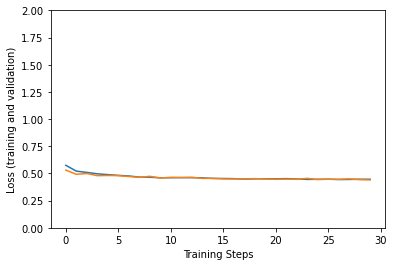

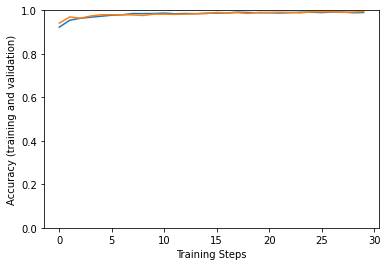

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

## Try out the model on an image from the validation data:

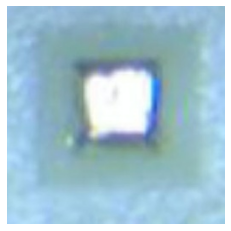

NameError: ignored

(1, 256, 256, 3)


In [ ]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

## save model

In [ ]:
model_name = "inceptionv3_299"
model_path = '/content/drive/MyDrive/AICUP2021/saved_model/{}'.format(model_name)
# ! mkdir /content/drive/MyDrive/AICUP2021/saved_model/$model_name

# saved_model_path = f"/content/drive/MyDrive/AICUP2021/saved_model/{model_name}/"
# # saved_model_path = f"/tmp/saved_flowers_model_{model_name}"
# tf.saved_model.save(model, saved_model_path)
! rm -rf /content/drive/MyDrive/AICUP2021/saved_model/$model_name
model.save(model_path)
! ls /content/drive/MyDrive/AICUP2021/saved_model/$model_name

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AICUP2021/saved_model/inceptionv3_299/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AICUP2021/saved_model/inceptionv3_299/assets


assets	keras_metadata.pb  saved_model.pb  variables


## Convert model to ONNX

In [ ]:
! pip install -U tf2onnx
! pip install onnxruntime

     |████████████████████████████████| 435 kB 5.3 MB/s 
     |████████████████████████████████| 12.8 MB 48.2 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


     |████████████████████████████████| 4.9 MB 5.3 MB/s 


In [ ]:
output_path = "/content/drive/MyDrive/AICUP2021/saved_onnx_model/{}.onnx".format(model_name)
! python -m tf2onnx.convert --saved-model $model_path --output $output_path
! ls /content/drive/MyDrive/AICUP2021/saved_onnx_model/

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-03-08 04:28:30,322 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-03-08 04:28:43,712 - INFO - Signatures found in model: [serving_default].
2022-03-08 04:28:43,712 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-03-08 04:28:43,714 - INFO - Output names: ['dense_2']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-03-08 04:28:48,476 - WARNING - From /usr/local/lib/python3.7/dist-packages/tf2onnx/tf_loader.py:706: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-03-08 04:28:50,850 - INFO - Using ten

In [ ]:
import onnx
onnx_model = onnx.load(output_path)
# # Check the model
try:
    onnx.checker.check_model(onnx_model)
except onnx.checker.ValidationError as e:
    print('The model is invalid: %s' % e)
else:
    print('The model is valid!')

The model is valid!


# load saved model

In [ ]:
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
new_model = tf.keras.models.load_model('/content/drive/MyDrive/AICUP2021/saved_model/{}'.format(model_name))
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
# dir_name = "/content/station4_white_pin2021-2-23_1614072478/testing_data/"
dir_name = "/content/station4_white_pin2021-2-23_1614072478/training_data/"
# dir_name = "/content/station4_white_pin2021-2-9_1612936555/testing_data/"
ok_dir = dir_name + "ok"
# ok_dir = dir_name + "ng"
print(len(os.listdir(ok_dir)))

4491
